In [6]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from scipy.ndimage import median_filter, gaussian_filter, sobel
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import joblib


In [7]:
#First step, we make our train/test split (60k each class for training, testing will be last 10k of each level + mnist) 
#we have 13 levels of obfuscation, so 4615 from each is 59995 for our label "corrupted"
#we take all of the uncorrupted images from mnist for our labeled "uncorrupted" (first 60k) 
corrupted_imgs = np.empty((0, 28, 28))
test_corrupted = np.empty((0, 28, 28))
for i in range(0, 56000, 4615): 
    #take from i to i+4614 for the training set and set its label to 1 (for corrupted = true) 
    file_num = int((i/4615)*5 + 10) # get the number of the thing we should be on 
    current_np = np.load("mnist_obfuscated/mnist_" + str(file_num) + ".npy")
    corrupted_imgs = np.concatenate((corrupted_imgs, current_np[i:i+4615]), axis = 0)
    test_corrupted = np.concatenate((test_corrupted, current_np[69230:]), axis = 0)
print(corrupted_imgs.shape)
print(test_corrupted.shape)
np.save("mnist_obfuscated/training", corrupted_imgs)



(59995, 28, 28)
(10010, 28, 28)


In [8]:
clean_imgs = np.load('mnist_files/mnist_img.npy') 
test_clean = clean_imgs[60000:]
clean_imgs = clean_imgs[:60000]


In [9]:
#now, we combine them and add labels 
train_corrupted = 59995
train_clean = 60000
num_test_corrupted = 10010
num_test_clean = 10000

train_data = np.concatenate((corrupted_imgs, clean_imgs), axis = 0)
train_labels = np.concatenate([np.ones(train_corrupted), np.zeros(train_clean)])
test_data = np.concatenate((test_corrupted, test_clean), axis = 0)
test_labels = np.concatenate([np.ones(num_test_corrupted), np.zeros(num_test_clean)])

In [10]:
#Second step, we perform normalization and denoising before extracting features - do to both the train and test data 

def denoise_image(image):
    """Apply median filter and gaussian filter."""
    image = image.astype(np.float32) / 255.0  # Normalize to [0,1]

    # Remove salt-and-pepper noise
    image = median_filter(image, size=3)

    # Remove Gaussian noise
    image = gaussian_filter(image, sigma=1)

    #ensure validity 
    image = np.clip(image, 0, 1)

    return image

def extract_features(image):
    """Extract classic features: flattened pixels + histogram + edge count."""

    features = []

    # 1. Flattened raw pixels
    flat_pixels = image.flatten()
    features.append(flat_pixels)

    # 2. Histogram of pixel intensities
    # 16 bins between 0 and 1 (since image normalized to [0,1])
    hist, _ = np.histogram(image, bins=16, range=(0.0, 1.0))
    hist = hist / np.sum(hist)  # Normalize histogram
    features.append(hist)

    # 3. Edge magnitude (Sobel)
    dx = sobel(image, axis=0, mode='constant')
    dy = sobel(image, axis=1, mode='constant')
    edge_magnitude = np.hypot(dx, dy)

    # Edge features
    mean_edge_strength = np.mean(edge_magnitude)
    total_edge_strength = np.sum(edge_magnitude)
    features.append([mean_edge_strength, total_edge_strength])

    # Combine all features into a single 1D vector
    return np.concatenate(features)

def prepare_dataset(images):
    processed_images = []

    for img in images:
        denoised_img = denoise_image(img)
        features = extract_features(denoised_img)
        processed_images.append(features)

    return np.array(processed_images)



In [11]:
#normalize, denoise, and feature extract the data from test and train 
train_features = prepare_dataset(train_data)
test_featrues = prepare_dataset(test_data)
print(train_features.shape)

(119995, 802)


In [12]:
#Third, we scale our data
scaler = StandardScaler()
X_train = scaler.fit_transform(train_features)
X_test = scaler.fit_transform(test_featrues)
#too computationally expensive for now 
# #set the hyperparam grid for the SVM 
# param_grid = {'C': [0.1, 1, 10, 100, 1000]}

# #perform grid_search using cross validation 
# grid_search = GridSearchCV(SVC(kernel='linear'), param_grid, cv=5, scoring='accuracy', verbose=2)
# grid_search.fit(X_train, train_labels)

# #now that we have the best C, we save it 
# best_C = grid_search.best_params_['C']
# print(f"Best C value: {best_C}")


In [8]:
    #Train the model with the best C
    clf = LinearSVC(C=1.0, max_iter=10000)
    clf.fit(X_train, train_labels)

    #Evaluate the classifier
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(test_labels, y_pred)
    print(f"Test Accuracy with C=1: {accuracy:.4f}")

Test Accuracy with C=1: 0.9156


In [9]:
joblib.dump(clf, "svm_model2.pkl")

['svm_model2.pkl']

In [14]:
#model1 is with noise, model2 is without noise in training
clf = joblib.load('svm_model2.pkl')


In [15]:
#lets find at what levels it is the most accurate
#general again
y_pred = clf.predict(X_test)
accuracy = accuracy_score(test_labels, y_pred)
print(f"Test Accuracy with C=1: {accuracy:.4f}")

different_level_accuracy = {}
for i in range (0, 13):
    obf_level = i*5 + 10 
    low = i*770
    high = low+770
    test_this = X_test[low:high]
    level_labels = test_labels[low:high]
    y_pred = clf.predict(test_this)
    accuracy = accuracy_score(y_pred, level_labels)
    print(f"Test Accuracy with obf_level {obf_level}: {accuracy:.4f}")
    different_level_accuracy[obf_level] = accuracy 

Test Accuracy with C=1: 0.9156
Test Accuracy with obf_level 10: 0.3143
Test Accuracy with obf_level 15: 0.5117
Test Accuracy with obf_level 20: 0.7013
Test Accuracy with obf_level 25: 0.8156
Test Accuracy with obf_level 30: 0.9195
Test Accuracy with obf_level 35: 0.9766
Test Accuracy with obf_level 40: 0.9948
Test Accuracy with obf_level 45: 0.9987
Test Accuracy with obf_level 50: 1.0000
Test Accuracy with obf_level 55: 1.0000
Test Accuracy with obf_level 60: 1.0000
Test Accuracy with obf_level 65: 1.0000
Test Accuracy with obf_level 70: 1.0000


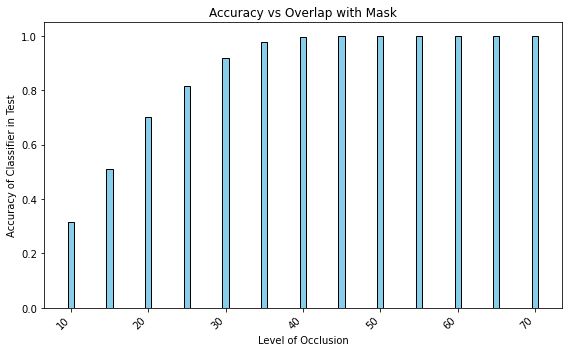

In [29]:
#lets make that into a chart now 
keys = list(different_level_accuracy.keys())
values = list(different_level_accuracy.values())

plt.figure(figsize=(8, 5))
plt.bar(keys, values, color='skyblue', edgecolor='black')
plt.title("Accuracy vs Overlap with Mask")
plt.xlabel("Level of Occlusion")
plt.ylabel("Accuracy of Classifier in Test")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("mnist_obfuscated/accuracy_level.png", dpi=300)
plt.show()


In [17]:
#next, we need a chart for the type of occlusion vs accuracy: get the type of occlusion from the mask folder
#figure out which tests have their index as each thing in that occlusion type table 
circle_obs = np.empty((0, 802))
polygon_obs = np.empty((0, 802))
region_obs = np.empty((0, 802))

for i in range (0, 13):
    level_of_obfuscation = i*5 + 10 
    low = i*770
    high = low+770
    test_this = X_test[low:high]
    level_labels = test_labels[low:high]
    type_array = np.load("mask/obfuscation_type_" + str(level_of_obfuscation) + ".npy")
    circle_bitmask = type_array[69230:] == "c"
    polygon_bitmask = type_array[69230:] == "p"
    region_bitmask = type_array[69230:] == "r"
    filtered = test_corrupted[i*770:i*770+770]
    circle_filtered = test_this[circle_bitmask]
    polygon_filtered = test_this[polygon_bitmask]
    region_filtered = test_this[region_bitmask]
    print(circle_filtered.shape)
    #now append the filtered to their corresponding arrays
    circle_obs = np.concatenate((circle_obs, circle_filtered), axis = 0)
    polygon_obs = np.concatenate((polygon_obs, polygon_filtered), axis = 0)
    region_obs = np.concatenate((region_obs, region_filtered), axis = 0)
#need to redo the processing from image to features on these to run them 
print(circle_obs.shape)

    
    

(301, 802)
(272, 802)
(293, 802)
(273, 802)
(308, 802)
(287, 802)
(279, 802)
(274, 802)
(311, 802)
(276, 802)
(294, 802)
(297, 802)
(288, 802)
(3753, 802)


In [18]:
X_circle = circle_obs
X_polygon = polygon_obs
X_region = region_obs

#need labels equal to their size 

y_circle = np.ones(X_circle.shape[0])
y_polygon = np.ones(X_polygon.shape[0])
y_region = np.ones(X_region.shape[0])

In [19]:
#now we fit to test them! 
y_pred = clf.predict(X_circle)
c_accuracy = accuracy_score(y_pred, y_circle)
print(f"Accuracy is {c_accuracy}")

y_pred = clf.predict(X_polygon)
p_accuracy = accuracy_score(y_pred, y_polygon)
print(f"Accuracy is {p_accuracy}")

y_pred = clf.predict(X_region)
r_accuracy = accuracy_score(y_pred, y_region)
print(f"Accuracy is {r_accuracy}")

Accuracy is 0.9144684252597922
Accuracy is 0.8843042071197411
Accuracy is 0.8007926023778071


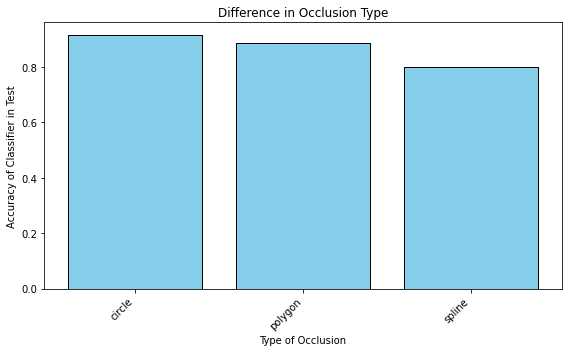

In [20]:
accuracy_dict = {"circle": c_accuracy, "polygon": p_accuracy, "spline": r_accuracy}
#lets make that into a chart now 
keys = list(accuracy_dict.keys())
values = list(accuracy_dict.values())
plt.figure(figsize=(8, 5))
plt.bar(keys, values, color='skyblue', edgecolor='black')
plt.title("Difference in Occlusion Type")
plt.xlabel("Type of Occlusion")
plt.ylabel("Accuracy of Classifier in Test")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("mnist_obfuscated/type_of_obfuscation.png", dpi=300)
plt.show()